# Radice Analysis

In [1]:
import os
import dataclasses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns

## Helper Functions

In [2]:
def figsize(height=None, twocolumn=True):
    width_pt = 448.1309 if twocolumn else 241.1474
    width = (width_pt / 72.27) # LaTeX linewidth divided by DPI
    if not height:
        height = width / ((1 + 5 ** 0.5) / 2)
    return width, height

In [3]:
def align_labels(ax, va=None, ha=None, ma=None, offset=0.8, axis="x"):
    if axis == "x":
        x = ax.xaxis
    else:
        x = ax.yaxis
    
    for lab in x.get_ticklabels():
        if ha:
            lab.set_horizontalalignment(ha)
        if va:
            lab.set_verticalalignment(va)
        if ma:
            lab.set_multialignment(ma)
    fontsize = x.get_ticklabels()[0].get_size()
    ax.tick_params(axis=axis, pad=fontsize+offset)

In [4]:
def compute_monthly_risk(risk, keys=['id'], observed=False):
    """
    Compute the monthly risk for the specified keys.

    :param risk: The raw data to compute the monthly risk from.
    :param keys: The grouping keys.
    :return: The risk grouped by the period, keys and seed.
    """
    group = keys + ['seed']
    as_index = True
    
    if 'month' in risk.columns:
        group.append('month')
        as_index = False
    else:
        group.append(risk['timestamp'].dt.month.rename('month'))
    
    res = risk.groupby(group, sort=False, as_index=as_index, observed=observed)['cost'].sum()
    
    if as_index:
        return res.reset_index()
    return res

In [5]:
def adjust_env(risk, energy_price=300, co2_price=64, social_co2_price=360.11, pue=1.57):
    """
    Adjust the prices of the environmental risk.
    :param risk: The raw data to adjust.
    :param energy_price: The price of energy per MWh
    :param co2_price: The price per tCO2
    :param social_co2_price: The social price per tCO2
    :param pue: The PUE of the datacenter.
    :return: The adjusted risk values.
    """
    id = risk['id']
    cost = risk['cost'] \
        .where(id != 'company:power', risk['value'] * (energy_price / 1000) * (pue / 1.57)) \
        .where(id != 'company:co2', risk['value'] * (co2_price / 1000) * (pue / 1.57)) \
        .where(id != 'society:co2', risk['value'] * (social_co2_price / 1000) * (pue / 1.57))
    return risk.assign(cost=cost)

In [6]:
def adjust_pue(risk, pue=1.57, co2_factor=0.556):
    """
    Adjust the PUE of the datacenter.
    :param risk: The raw risk data.
    :param pue: The new PUE of the datacenter.
    :param co2_factor: The new CO2 factor to use.
    :return: The adjusted risk values.
    """
    id = risk['id']
    cost = risk['cost'] \
        .where(id != 'company:power', risk['cost'] * (pue / 1.57)) \
        .where(id != 'company:co2', risk['cost'] * (pue / 1.57) * (co2_factor / 0.556)) \
        .where(id != 'society:co2', risk['cost'] * (pue / 1.57) * (co2_factor / 0.556))
    return risk.assign(cost=cost)

In [7]:
def adjust_co2(risk, co2_price=64, social_co2_price=360.11, pue=1.57):
    """
    Adjust the CO2 prices.
    :param risk: The raw risk data.
    :param co2_price: The price per tCO2.
    :param social_co2_price: The social price per tCO2.
    :param pue: The adjusted PUE of the datacenter.
    :return: The adjusted risk values.
    """
    id = risk['id']
    cost = risk['cost'] \
        .where(id != 'company:power', risk['cost'] * (pue / 1.57)) \
        .where(id != 'company:co2', risk['cost'] * (co2_price / 64) * (pue / 1.57)) \
        .where(id != 'society:co2', risk['cost'] * (social_co2_price / 360.11) * (pue / 1.57))
    return risk.assign(cost=cost)

In [8]:
def adjust_penalty(risk, penalties, vcpu_cost = 0.040):
    """
    Adjust the SLA penalties.
    :param risk: The raw risk data to adjust.
    :param penalties: The penalties to use.
    :return: The adjusted risk values.
    """
    av = risk['id'] == 'customer:availability'
    
    def m(av):
        for (bound, p) in penalties:
            if av < bound:
                return p
        return 0.0

    return risk.assign(cost=risk['cost'].where(~av, other=risk['cost'] * risk.loc[av, 'value'].apply(m)))

## Plot Setup

In [9]:
FIGURE_PATH = "figures"

os.makedirs(FIGURE_PATH, exist_ok=True)

In [10]:
font_scale = 0.8
theme = {
    "legend.fancybox": False,
    "legend.edgecolor": 'black',
    "xtick.major.pad": 0,
    "ytick.major.pad": 0,
}

rc = {
    "pdf.fonttype": 42,
    "figure.figsize": figsize(3),  # Derived from thesis dimensions
    "figure.autolayout": False,
    "figure.constrained_layout.use": True,
    "figure.dpi": 300,
}
    
sns.set_theme(style="darkgrid", rc=theme | rc, font_scale=font_scale)

## Shared Data

In [11]:
risk_baseline = pd.read_parquet("data/risk/portfolio=baseline/topology=base", columns=["seed", "timestamp", "id", "cost", "value"], read_dictionary=["id"])
risk_baseline

,seed,timestamp,id,cost,value
0,0,1970-01-14 23:59:59+00:00,customer:cpu_interference,0.096000,0.038738
1,0,1970-01-15 23:59:59+00:00,customer:cpu_interference,0.096000,0.038738
2,0,1970-01-16 23:59:59+00:00,customer:cpu_interference,0.096000,0.037338
3,0,1970-01-17 23:59:59+00:00,customer:cpu_interference,0.096000,0.039641
4,0,1970-01-18 23:59:59+00:00,customer:cpu_interference,0.096000,0.035336
...,...,...,...,...,...
1614062,999,1970-03-23 23:59:59+00:00,customer:cpu_interference,0.096000,0.035127
1614063,999,1970-03-23 23:59:59+00:00,customer:cpu_interference,0.096000,0.029294
1614064,999,1970-03-24 00:04:59.001000+00:00,company:power,3309.496291,11031.654302
1614065,999,1970-03-24 00:04:59.001000+00:00,company:co2,392.550387,6133.599792


In [12]:
@dataclasses.dataclass
class PriceScenario:
    title: str
    energy_price: int
    co2_price: int
    social_co2_price: int
    pue: float
    
price_scenarios = {
    "2021": PriceScenario(
        title="2021",
        energy_price=103,
        co2_price=54,
        social_co2_price=395,
        pue=1.5533,
    ),
    "2022": PriceScenario(
        title="2022",
        energy_price=241,
        co2_price=81,
        social_co2_price=395,
        pue=1.55,
    ),
    "2022-aug": PriceScenario(
        title="2022\n(Peak)",
        energy_price=693,
        co2_price=99,
        social_co2_price=395,
        pue=1.55,
    ),
    "prices-2x": PriceScenario(
        title="Prices 2x",
        energy_price=482,
        co2_price=162,
        social_co2_price=395,
        pue=1.55,
    ),
    "prices-10x": PriceScenario(
        title="Prices 10x",
        energy_price=2410,
        co2_price=810,
        social_co2_price=395,
        pue=1.55,
    ),
}

pue_scenarios = [1.1, 1.55, 2.5]

In [13]:
price_scenarios_risk = pd.concat([
    compute_monthly_risk(
        adjust_env(
            risk_baseline, 
            energy_price=scenario.energy_price, 
            co2_price=scenario.co2_price, 
            social_co2_price=scenario.social_co2_price, 
            pue=scenario.pue
        )
    ).assign(scenario=key)
    for key, scenario in price_scenarios.items()
])

pue_scenarios_risk = pd.concat([
    adjust_pue(price_scenarios_risk, pue=scenario).assign(pue=f"{scenario:.3g}")
    for scenario in pue_scenarios
])

In [14]:
risk_baseline_monthly = compute_monthly_risk(price_scenarios_risk[price_scenarios_risk["scenario"] == "2021"], keys=[])["cost"].mean()

## Figure 1 (Risk Profile)

In [15]:
fig_1_data_2021 = price_scenarios_risk[price_scenarios_risk["scenario"] == "2021"]
fig_1_data_2022 = price_scenarios_risk[price_scenarios_risk["scenario"] == "2022"]

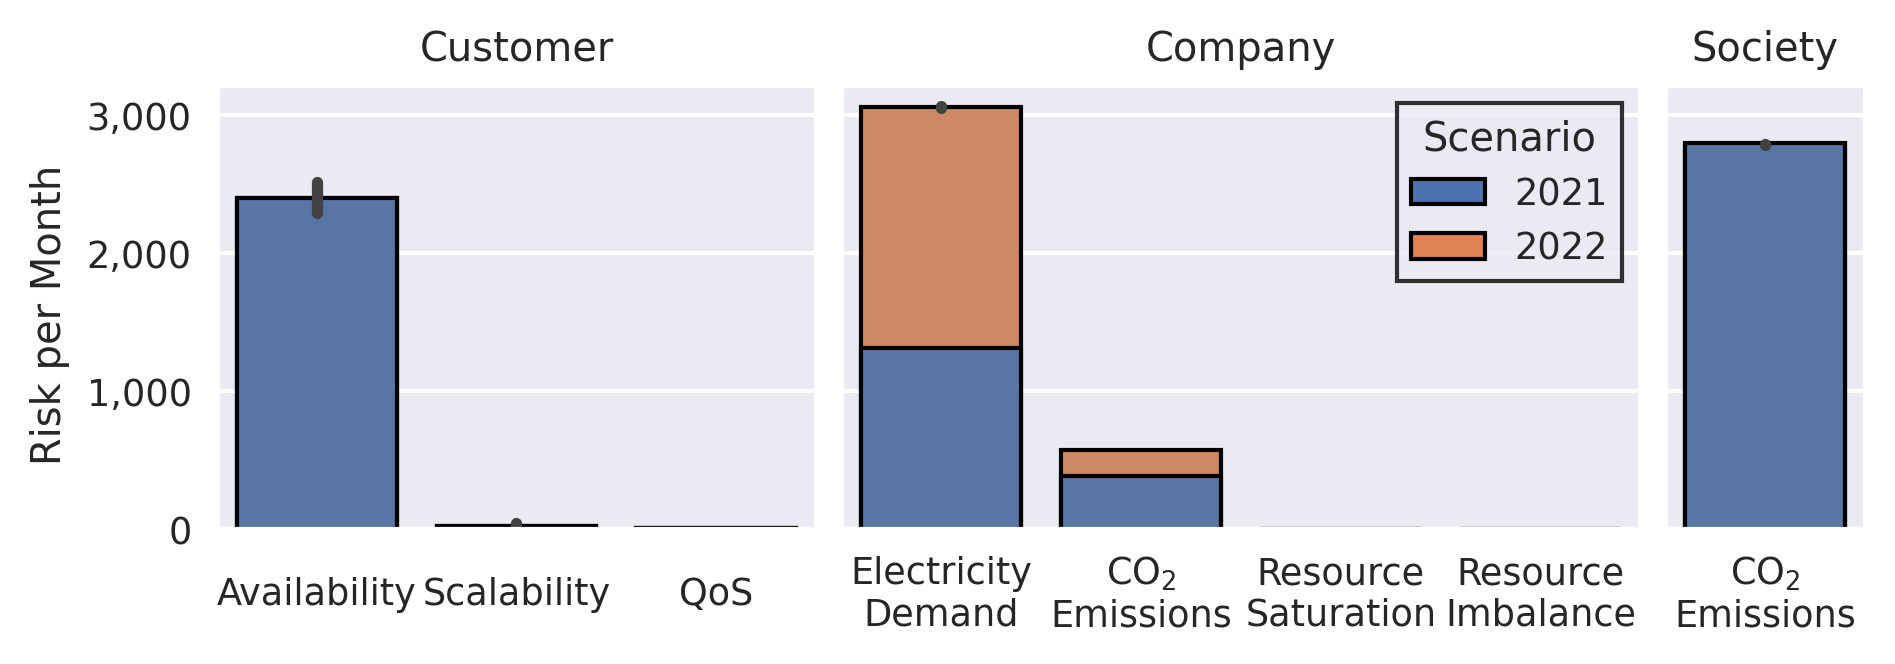

In [16]:
fig, ax = plt.subplots(1, 3, figsize=figsize(2.1), sharey=True, gridspec_kw={"width_ratios": [3, 4, 1]})

cx_order = ["customer:availability", "customer:latency", "customer:cpu_interference"]
cx_labels = ["Availability", "Scalability", "QoS"]

co_order = ["company:power", "company:co2", "company:host_saturation", "company:host_imbalance"]
co_labels = ["Electricity\nDemand", "CO$_2$\nEmissions", "Resource\nSaturation", "Resource\nImbalance"]

soc_order = ["society:co2"]
soc_labels = ["CO$_2$\nEmissions"]

sns.barplot(x="id", y="cost", data=fig_1_data_2021[fig_1_data_2021["id"].str.startswith("customer")], ax=ax[0], order=cx_order, edgecolor="black", color="C0", zorder=2, errorbar=None)
sns.barplot(x="id", y="cost", data=fig_1_data_2022[fig_1_data_2022["id"].str.startswith("customer")], ax=ax[0], order=cx_order, edgecolor="black", color="C1")

ax[0].set_ylabel("Risk per Month ")
ax[0].set_xticklabels(cx_labels)
ax[0].set_xlabel("")
ax[0].set_title("Customer")
ax[0].yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

patch_2021 = mpatches.Patch(facecolor="C0", edgecolor="black", label="2021")
patch_2022 = mpatches.Patch(facecolor="C1", edgecolor="black", label="2022")

legend = ax[1].legend(title="Scenario", handles=[patch_2021, patch_2022])

sns.barplot(x="id", y="cost", data=fig_1_data_2021[fig_1_data_2021["id"].str.startswith("company")], ax=ax[1], order=co_order, edgecolor="black", color="C0", zorder=2, errorbar=None)
sns.barplot(x="id", y="cost", data=fig_1_data_2022[fig_1_data_2022["id"].str.startswith("company")], ax=ax[1], order=co_order, edgecolor="black", color="C1")

ax[1].set_ylabel("")
ax[1].set_xticklabels(co_labels)
ax[1].set_xlabel("")
ax[1].set_title("Company")
ax[0].legend([],[], frameon=False)

sns.barplot(x="id", y="cost", data=fig_1_data_2021[fig_1_data_2021["id"].str.startswith("society")], ax=ax[2], order=soc_order, edgecolor="black", color="C0", zorder=2, errorbar=None)
sns.barplot(x="id", y="cost", data=fig_1_data_2022[fig_1_data_2022["id"].str.startswith("society")], ax=ax[2], order=soc_order, edgecolor="black", color="C1")

ax[2].set_ylabel("")
ax[2].set_xticklabels(soc_labels)
ax[2].set_xlabel("")
ax[2].set_title("Society")
ax[2].legend([],[], frameon=False)

fig.align_xlabels(ax)

for x in ax:
    align_labels(x, va="center")
    
fig.savefig(os.path.join(FIGURE_PATH, "figure-1.pdf"))

## Figure 5 (Electricity and CO2 prices)

In [17]:
electricity_price = pd.read_csv("data/electricity-price.csv")
electricity_price["timestamp"] = pd.to_datetime(electricity_price["timestamp"], unit="ms")
electricity_price

,timestamp,price_per_mwh
0,2015-01-06,42.22
1,2015-01-07,42.61
2,2015-01-08,42.43
3,2015-01-09,36.94
4,2015-01-10,36.25
...,...,...
2872,2023-02-10,133.13
2873,2023-02-11,137.67
2874,2023-02-12,142.24
2875,2023-02-13,158.16


In [18]:
co2_price = pd.read_csv("data/co2-price.csv")
co2_price["timestamp"] = pd.to_datetime(co2_price["timestamp"])
co2_price

,timestamp,price_per_t
0,2019-05-21,25.94
1,2019-05-22,26.93
2,2019-05-23,26.62
3,2019-05-24,26.03
4,2019-05-27,26.15
...,...,...
995,2023-03-24,85.10
996,2023-03-27,85.04
997,2023-03-28,86.88
998,2023-03-29,87.81


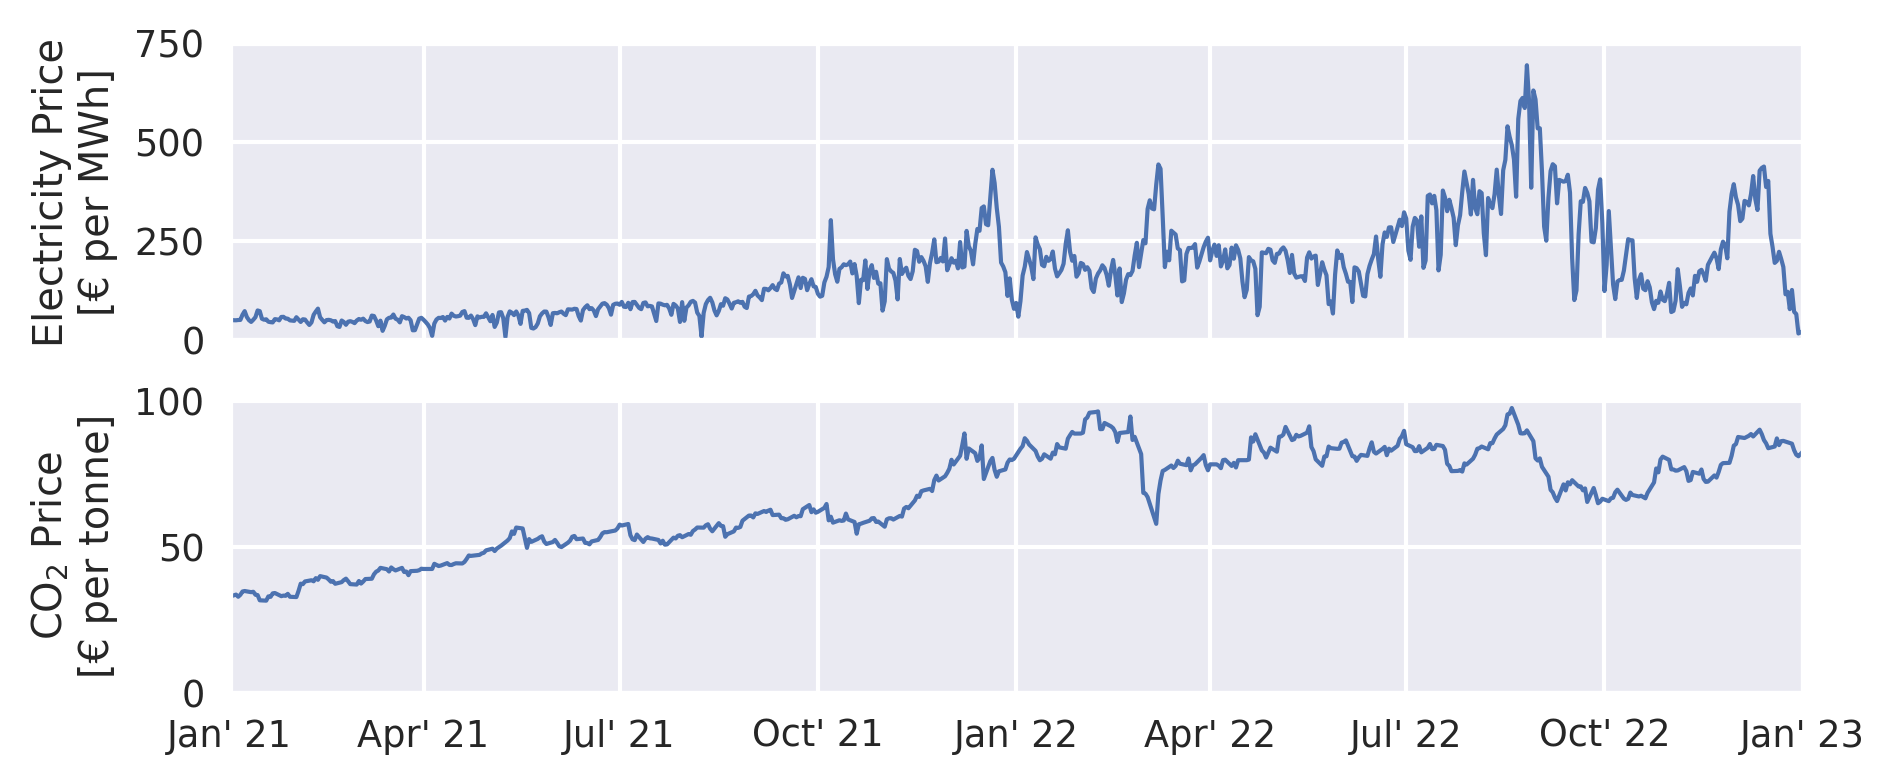

In [22]:
fig, ax = plt.subplots(2, 1, figsize=figsize(2.5), sharex=True)

sns.lineplot(data=electricity_price, x="timestamp", y="price_per_mwh", ax=ax[0], linewidth=1)

ax[0].set_ylabel("Electricity Price\n[€ per MWh]")
ax[0].set_xlabel("")
ax[0].set_ylim(bottom=0, top=750)
ax[0].set_yticks([0, 250, 500, 750])

sns.lineplot(data=co2_price, x="timestamp", y="price_per_t", linewidth=1, ax=ax[1])

ax[1].set_ylabel("CO$_2$ Price\n[€ per tonne]")
ax[1].set_xlabel("")
ax[1].set_ylim(bottom=0)

xmin=pd.to_datetime("2021-01-01", format="%Y-%m-%d")
xmax=pd.to_datetime("2023-01-01", format="%Y-%m-%d")
ax[1].set_xlim(left=xmin, right=xmax)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b' %y"))

fig.align_ylabels(ax)
fig.savefig(os.path.join(FIGURE_PATH, "figure-5.pdf"))

## Figure 6 (Price Surges)

In [23]:
fig_6_data = pue_scenarios_risk
fig_6_data = fig_6_data.groupby(["seed", "scenario", "pue", "month"])["cost"].sum().to_frame().reset_index()
fig_6_data["pct"] = fig_6_data["cost"] / risk_baseline_monthly
fig_6_data

,seed,scenario,pue,month,cost,pct
0,0,2021,1.1,1,3382.262802,0.488955
1,0,2021,1.1,2,3376.582848,0.488134
2,0,2021,1.1,3,2701.926467,0.390603
3,0,2021,1.55,1,4764.534677,0.688783
4,0,2021,1.55,2,4755.123832,0.687422
...,...,...,...,...,...,...
184315,999,prices-2x,1.55,2,10832.723326,1.566027
184316,999,prices-2x,1.55,3,8519.679796,1.231643
184317,999,prices-2x,2.5,1,17201.379173,2.486709
184318,999,prices-2x,2.5,2,17343.991242,2.507326


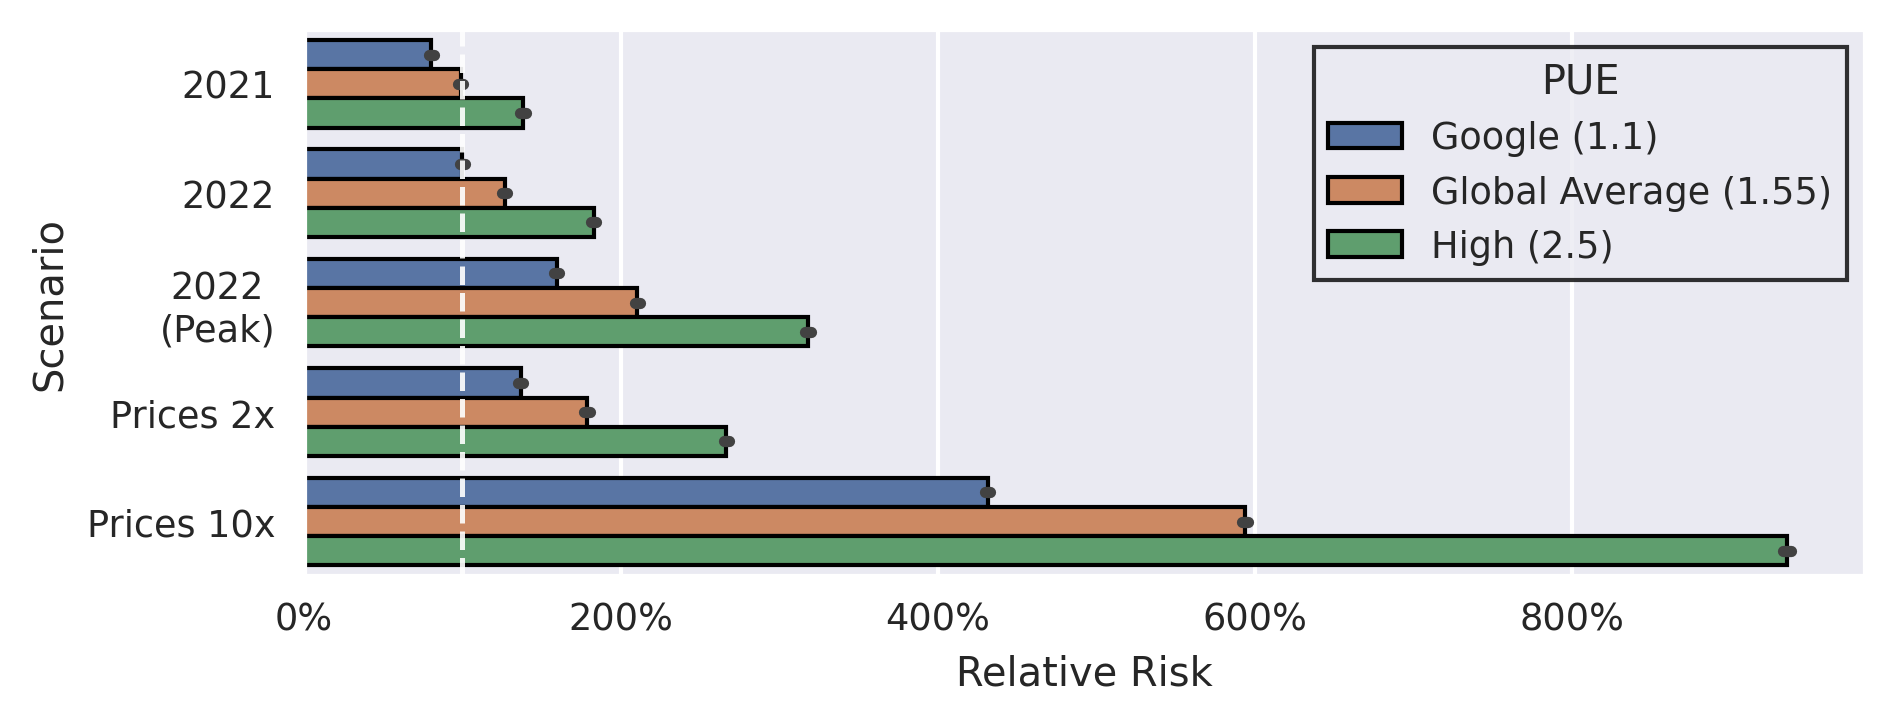

In [24]:
fig, ax = plt.subplots(1, figsize=figsize(2.3))

order=["2021", "2022", "2022-aug", "prices-2x", "prices-10x"]

sns.barplot(data=fig_6_data, x="pct", y="scenario", hue="pue", ax=ax, edgecolor="black", order=price_scenarios.keys())

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel("Relative Risk")
ax.set_ylabel("Scenario")
ax.set_yticklabels([scenario.title for scenario in price_scenarios.values()])

legend = ax.get_legend()
legend.set_title("PUE")
labels = ["Google (1.1)", "Global Average (1.55)", "High (2.5)"]

for i, txt in enumerate(legend.get_texts()):
    txt.set_text(labels[i])

ax.axvline(1, color="w", alpha=0.9, linestyle="dashed", lw=1.2)

align_labels(ax, axis="y", ma="center", offset=-8)

fig.savefig(os.path.join(FIGURE_PATH, "figure-6.pdf"))

## Figure 7 (CO2 Costs)

In [25]:
def map_group(identifier):
    if identifier == 'company:co2' or identifier == 'society:co2':
        return identifier
    else:
        return 'other'

operating_margin = 1.20

fig_7_baseline = price_scenarios_risk[price_scenarios_risk["scenario"] == "2022"]

fig_7_group_costs = fig_7_baseline.assign(group=fig_7_baseline['id'].apply(map_group))
fig_7_group_costs = fig_7_group_costs.groupby(['group', 'seed', 'month'])['cost'].sum().reset_index()
fig_7_group_costs = pd.concat([
    fig_7_group_costs,
    fig_7_group_costs.groupby(['seed', 'month'])['cost'].sum().reset_index().assign(group='all'),
    (fig_7_group_costs.groupby(['seed', 'month'])['cost'].sum() * operating_margin).reset_index().assign(group='revenue')
])
fig_7_group_costs['fraction'] = fig_7_group_costs['cost'] / fig_7_group_costs.loc[fig_7_group_costs['group'] == 'all', 'cost'].mean()
fig_7_group_costs

fig_7_co2_cost = fig_7_baseline
fig_7_co2_cost = pd.concat([
    adjust_co2(fig_7_co2_cost, co2_price=81 * 2).assign(co2_price=81 * 2),
    adjust_co2(fig_7_co2_cost, co2_price=81 * 5).assign(co2_price=81 * 5),
    adjust_co2(fig_7_co2_cost, co2_price=81 * 10).assign(co2_price=81 * 10),
])
fig_7_co2_cost = pd.concat([
    fig_7_co2_cost.groupby(['co2_price', 'seed', 'month'])['cost'].sum().reset_index().assign(group='all'),
    fig_7_co2_cost[fig_7_co2_cost['id'] == 'company:co2'].groupby(['co2_price', 'seed', 'month'])['cost'].sum().reset_index().assign(group='company:co2'),
])
fig_7_co2_cost['fraction'] = fig_7_co2_cost['cost'] / fig_7_group_costs.loc[fig_7_group_costs['group'] == 'all', 'cost'].mean()
fig_7_co2_cost

,co2_price,seed,month,cost,group,fraction
0,162,0,1,7844.877335,all,0.886330
1,162,0,2,7827.152333,all,0.884327
2,162,0,3,6264.116165,all,0.707732
3,162,1,1,7903.818338,all,0.892989
4,162,1,2,42106.715402,all,4.757300
...,...,...,...,...,...,...
36859,810,998,2,7751.075163,company:co2,0.875732
36860,810,998,3,6212.484352,company:co2,0.701899
36861,810,999,1,7776.045490,company:co2,0.878553
36862,810,999,2,7747.297108,company:co2,0.875305


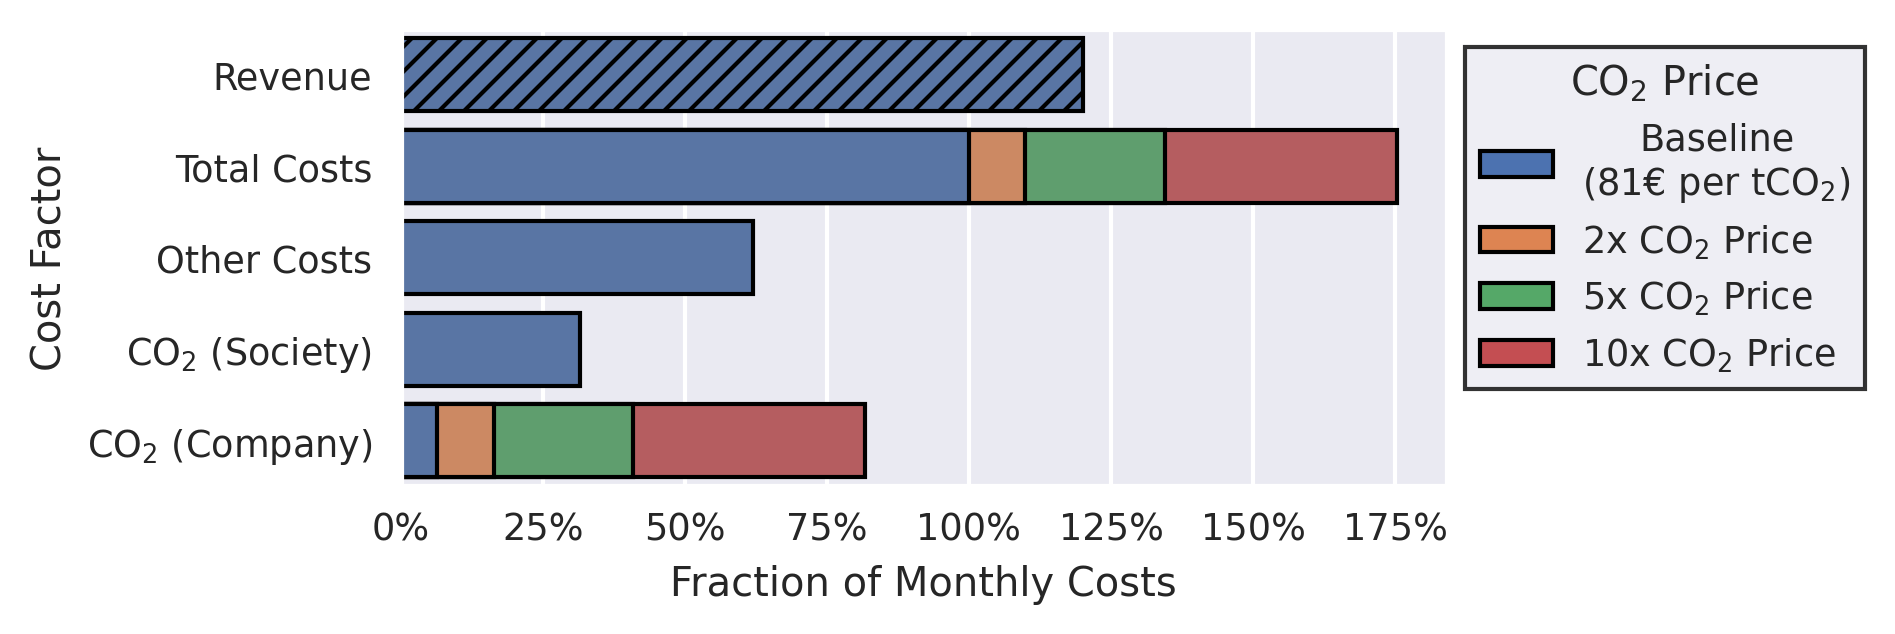

In [26]:
fig, ax = plt.subplots(1, figsize=figsize(2))

order = ["revenue", "all", "other", "society:co2", "company:co2"]

bar = sns.barplot(data=fig_7_group_costs, x="fraction", y="group", ax=ax, edgecolor="black", order=order, errorbar=None, zorder=2, color="C0")
bar.patches[0].set_hatch("////")

sns.barplot(data=fig_7_co2_cost[fig_7_co2_cost["co2_price"] == 81 * 2], x="fraction", y="group", ax=ax, edgecolor="black", order=order, errorbar=None, zorder=1.9, color="C1")
sns.barplot(data=fig_7_co2_cost[fig_7_co2_cost["co2_price"] == 81 * 5], x="fraction", y="group", ax=ax, edgecolor="black", order=order, errorbar=None, zorder=1.8, color="C2")
sns.barplot(data=fig_7_co2_cost[fig_7_co2_cost["co2_price"] == 81 * 10], x="fraction", y="group", ax=ax, edgecolor="black", order=order, errorbar=None, color="C3")

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_xlabel("Fraction of Monthly Costs")
ax.set_ylabel("Cost Factor")
ax.set_yticklabels([
    "Revenue",
    "Total Costs",
    "Other Costs",
    "CO$_2$ (Society)",
    "CO$_2$ (Company)",
], usetex=False)

patch_baseline = mpatches.Patch(facecolor="C0", edgecolor="black", label="Baseline\n(81€ per tCO$_2$)")
patch_2x = mpatches.Patch(facecolor="C1", edgecolor="black", label="2x CO$_2$ Price")
patch_5x = mpatches.Patch(facecolor="C2", edgecolor="black", label="5x CO$_2$ Price")
patch_10x = mpatches.Patch(facecolor="C3", edgecolor="black", label="10x CO$_2$ Price")

legend = ax.legend(bbox_to_anchor=(1, 1), loc="upper left", title="CO$_2$ Price", handles=[patch_baseline, patch_2x, patch_5x, patch_10x])
txt = legend.get_texts()
txt[0].set_ma("center")

align_labels(ax, ha="right", axis="y", offset=-8)

fig.savefig(os.path.join(FIGURE_PATH, "figure-7.pdf"))

## Figure 8a (Availability)

In [27]:
risk_failures = pd.read_parquet('data/risk/portfolio=phenomena/scenario=failures', columns=["seed", "timestamp", "id", "value", "cost"], read_dictionary=["id"])
risk_failures["group"] = risk_failures["id"].str.split(":", n=1).str[0]
risk_failures

,seed,timestamp,id,value,cost,group
0,0,1970-01-14 23:59:59+00:00,customer:cpu_interference,0.038738,0.096000,customer
1,0,1970-01-15 23:59:59+00:00,customer:cpu_interference,0.038738,0.096000,customer
2,0,1970-01-16 23:59:59+00:00,customer:cpu_interference,0.037338,0.096000,customer
3,0,1970-01-17 23:59:59+00:00,customer:cpu_interference,0.039641,0.096000,customer
4,0,1970-01-18 23:59:59+00:00,customer:cpu_interference,0.035336,0.096000,customer
...,...,...,...,...,...,...
2571538,999,1970-03-23 23:59:59+00:00,customer:cpu_interference,0.035127,0.096000,customer
2571539,999,1970-03-23 23:59:59+00:00,customer:cpu_interference,0.029294,0.096000,customer
2571540,999,1970-03-24 00:04:59.001000+00:00,company:power,11031.654302,3309.496291,company
2571541,999,1970-03-24 00:04:59.001000+00:00,company:co2,6133.599792,392.550387,company


In [28]:
failure_scenarios = {
    "0.9": [(0.85, 1.0), (0.875, 0.3), (0.90, 0.1)],
    "0.99": [(0.95, 1.0), (0.975, 0.3), (0.99, 0.1)],
    "0.995": [(0.95, 1.0), (0.99, 0.3), (0.995, 0.1)],
    "0.999": [(0.99, 1.0), (0.995, 0.3), (0.999, 0.1)],
    "0.9999": [(0.999, 1.0), (0.9995, 0.3), (0.9999, 0.1)],
    "0.99999": [(0.9999, 1.0), (0.99995, 0.3), (0.99999, 0.1)],
    "0.999999": [(0.99999, 1.0), (0.999995, 0.3), (0.999999, 0.1)],
    "0.9999999": [(0.999999, 1.0), (0.9999995, 0.3), (0.9999999, 0.1)],
}

In [29]:
failure_scenarios_risk = pd.concat([
    adjust_penalty(risk_failures, scenario).assign(target=key)
    for key, scenario in failure_scenarios.items()
])
failure_scenarios_risk = compute_monthly_risk(failure_scenarios_risk[failure_scenarios_risk['group'] == 'customer'], keys=['target', 'group']).reset_index()

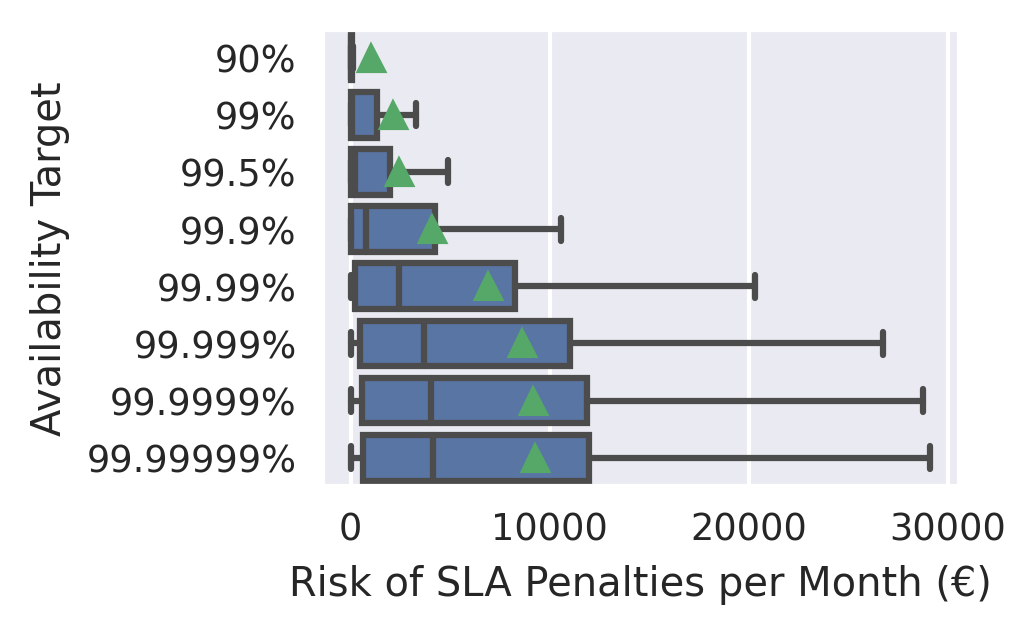

In [30]:
fig, ax = plt.subplots(figsize=figsize(2, False))

ax = sns.boxplot(data=failure_scenarios_risk, x="cost", y="target", ax=ax, order=failure_scenarios.keys(), showfliers=False, showmeans=True, palette=["C0"])

ax.set_ylabel("Availability Target")
ax.set_xlabel("Risk of SLA Penalties per Month (€)")
ax.set_yticklabels(["90%", "99%", "99.5%", "99.9%", "99.99%", "99.999%", "99.9999%", "99.99999%"])

fig.savefig(os.path.join(FIGURE_PATH, "figure-8a.pdf"))

## Figure 8b (Contention)

In [31]:
interference = pd.read_parquet("data/interference/portfolio=phenomena", columns=["scenario", "seed", "interference"])
interference = interference.groupby(["scenario", "seed"]).sum().reset_index()
interference

,scenario,seed,interference
0,baseline,0,2626226
1,baseline,1,2675226
2,baseline,10,2009371
3,baseline,100,2335567
4,baseline,1000,2585012
...,...,...,...
20475,none,995,346776
20476,none,996,346776
20477,none,997,346776
20478,none,998,346776


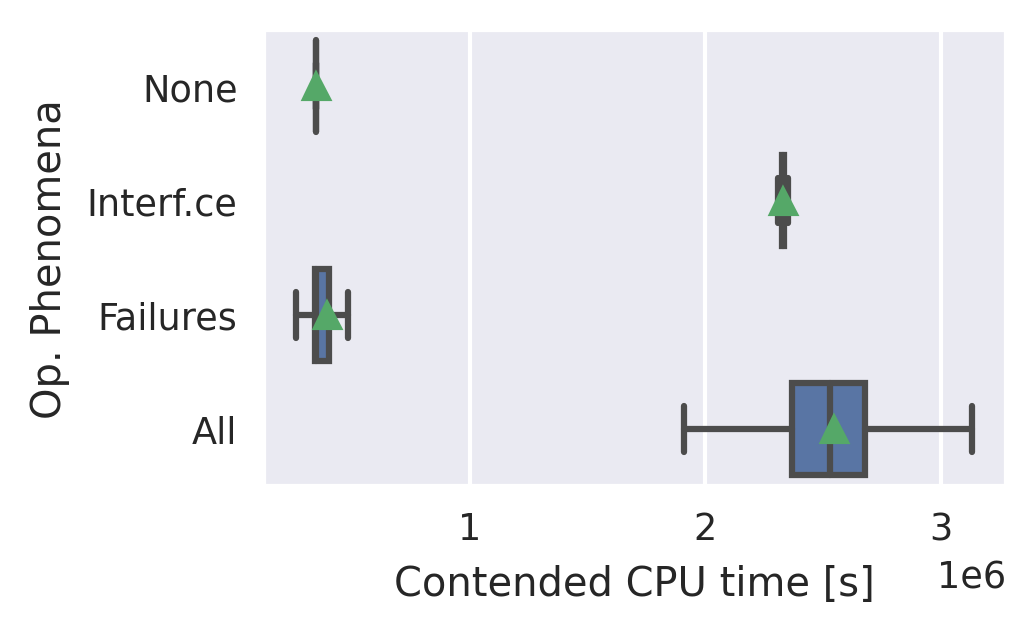

In [32]:
fig, ax = plt.subplots(figsize=figsize(2, False))

order=["none", "no-failures", "no-interference", "baseline"]
sns.boxplot(data=interference, x="interference", y="scenario", order=order, showfliers=False, showmeans=True, ax=ax, palette=["C0"])

ax.set_ylabel("Op. Phenomena")
ax.set_yticklabels(["None", "Interf.ce", "Failures", "All"])
ax.set_xlabel("Contended CPU time [s]");

fig.savefig(os.path.join(FIGURE_PATH, "figue-8b.pdf"))

## Figure 9 (Topology Scale)

In [33]:
scale_mapping = {
    "base-12.5%": 0.125,
    "base-25%": 0.25,
    "base-37.5%": 0.375,
    "base-50%": 0.5,
    "base-75%": 0.75,
    "base-90%": 0.9,
    "base": 1,
    "base-150%": 1.5,
    "base-200%": 2,
    "base-300%": 3,
    "base-400%": 4,
}

risk_scale = pd.read_parquet('data/risk/portfolio=baseline', columns=['seed', 'timestamp', 'id', 'cost', 'topology'], read_dictionary=["id", "topology"])
risk_scale["scale"] = risk_scale["topology"].map(scale_mapping).astype('float')
risk_scale

,seed,timestamp,id,cost,topology,scale
0,0,1970-01-14 23:59:59+00:00,customer:cpu_interference,0.096000,base-12.5%,0.125
1,0,1970-01-15 23:59:59+00:00,customer:cpu_interference,0.096000,base-12.5%,0.125
2,0,1970-01-16 23:59:59+00:00,customer:cpu_interference,0.096000,base-12.5%,0.125
3,0,1970-01-17 23:59:59+00:00,customer:cpu_interference,0.096000,base-12.5%,0.125
4,0,1970-01-18 23:59:59+00:00,customer:cpu_interference,0.096000,base-12.5%,0.125
...,...,...,...,...,...,...
51929739,999,1970-03-23 23:59:59+00:00,customer:cpu_interference,0.096000,base,1.000
51929740,999,1970-03-23 23:59:59+00:00,customer:cpu_interference,0.096000,base,1.000
51929741,999,1970-03-24 00:04:59.001000+00:00,company:power,3309.496291,base,1.000
51929742,999,1970-03-24 00:04:59.001000+00:00,company:co2,392.550387,base,1.000


In [34]:
fig_9_data = compute_monthly_risk(risk_scale, keys=["id", "scale"])
fig_9_data = pd.concat([
    adjust_pue(fig_9_data, pue=scenario).assign(pue=f"{scenario:.3g}")
    for scenario in pue_scenarios
])

fig_9_baseline = compute_monthly_risk(risk_baseline, keys=[])["cost"].mean()

fig_9_data = fig_9_data.groupby(["seed", "scale", "pue", "month"])["cost"].sum().reset_index()
fig_9_data["increase"] = fig_9_data["cost"] / fig_9_baseline
fig_9_data = fig_9_data.groupby(["pue", "scale"]).mean(numeric_only=True).reset_index()
fig_9_data

,pue,scale,month,cost,increase
0,1.1,0.125,2.0,46725.542255,5.012583
1,1.1,0.250,2.0,25392.322742,2.724016
2,1.1,0.375,2.0,12393.335141,1.329522
3,1.1,0.500,2.0,8442.560916,0.905694
4,1.1,0.750,2.0,7120.211542,0.763836
5,1.1,0.900,2.0,7282.406282,0.781236
6,1.1,1.000,2.0,7258.359579,0.778656
7,1.1,1.500,2.0,8507.248245,0.912633
8,1.1,2.000,2.0,10151.964267,1.089074
9,1.1,3.000,2.0,14078.046555,1.510253


Optimization terminated successfully.
         Current function value: 0.730908
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.886848
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 1.193003
         Iterations: 14
         Function evaluations: 28


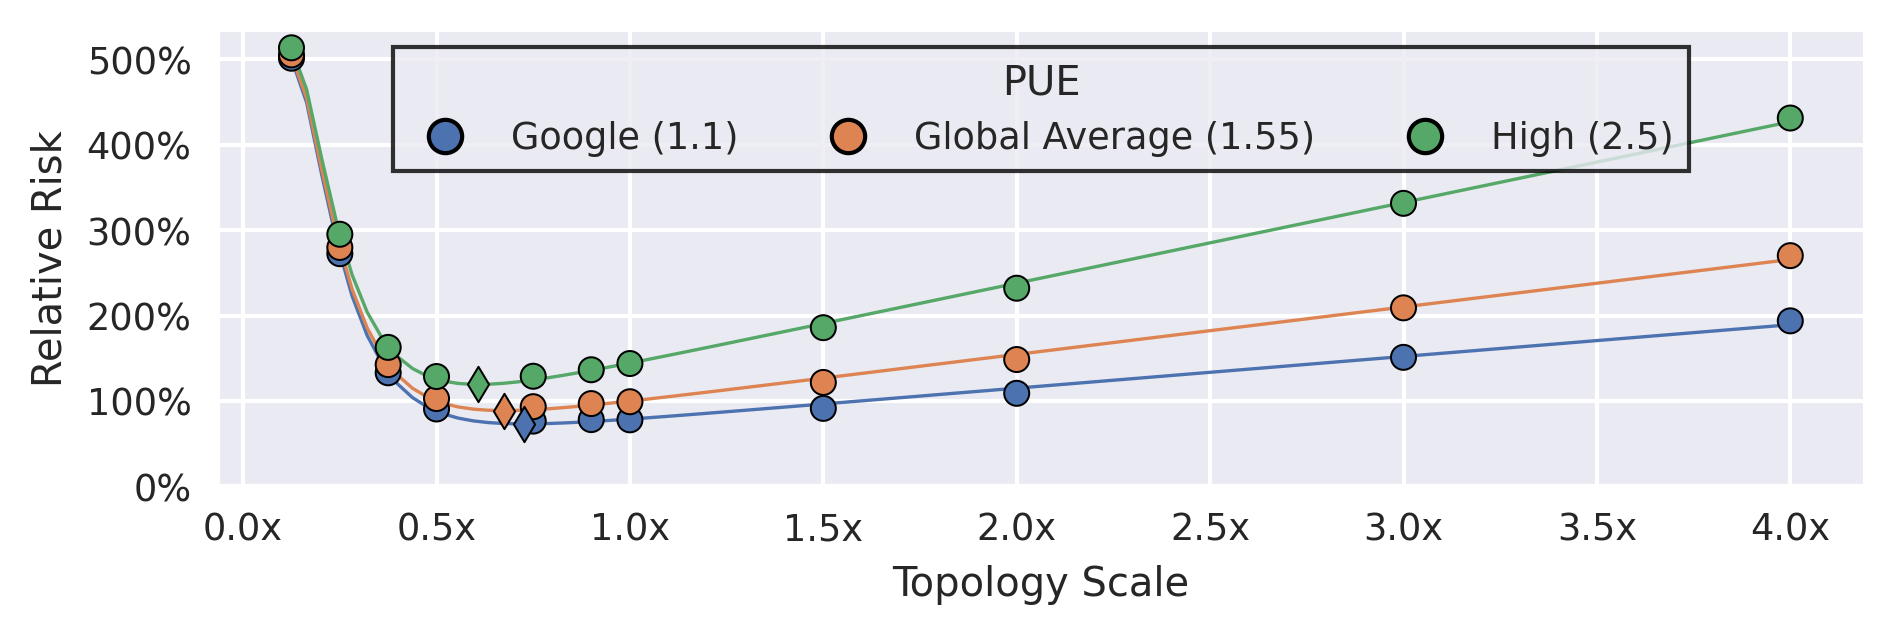

In [35]:
fig, ax = plt.subplots(1, figsize=figsize(2))

scale_opt_f = fig_9_baseline

def f(x, mu, sigma, a, b):
    return scipy.stats.lognorm.pdf(x, sigma, scale = np.exp(mu)) + a * x + b

for pue, group in fig_9_data.groupby("pue"):
    x = group["scale"]
    y = group["increase"]
    xp = np.linspace(x.min(), x.max(), 100)

    params, extras = scipy.optimize.curve_fit(f, x, y)
    xmin = scipy.optimize.fmin(lambda x: f(x, *params), 1)[0]

    sns.scatterplot(x=[xmin], y=[(f(xmin, *params) * 9321.649190) / scale_opt_f], ax=ax, edgecolor="black", zorder=150, marker="d")
    sns.lineplot(x=xp, y=(f(xp, *params) * 9321.649190) / scale_opt_f, ax=ax, linewidth=0.8)

sns.scatterplot(data=fig_9_data, x="scale", y="increase", hue="pue", ax=ax, edgecolor="black", zorder=100)

ax.xaxis.set_major_formatter("{x}x")
ax.set_xlabel("Topology Scale")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylabel("Relative Risk")
ax.set_ylim(bottom=0)

legend_elements = [
    mlines.Line2D([0], [0], marker="o", linestyle="None", markerfacecolor="C0", markeredgecolor="black", markersize=8, label="Google (1.1)"),
    mlines.Line2D([0], [0], marker="o", linestyle="None", markerfacecolor="C1", markeredgecolor="black", markersize=8, label="Global Average (1.55)"),
    mlines.Line2D([0], [0], marker="o", linestyle="None", markerfacecolor="C2", markeredgecolor="black", markersize=8, label="High (2.5)"),
]
    
legend = ax.legend(handles=legend_elements, title="PUE", loc="upper center", ncol=3)

fig.savefig(os.path.join(FIGURE_PATH, "figure-9.pdf"))

## Figure 10 (Optimization)

In [36]:
risk_opt = pd.read_parquet("data/risk/portfolio=topology-opt", columns=["candidate", "seed", "timestamp", "id", "cost"], read_dictionary=["id", "candidate"])

In [37]:
risk_opt_monthly = compute_monthly_risk(risk_opt, keys=["candidate"])

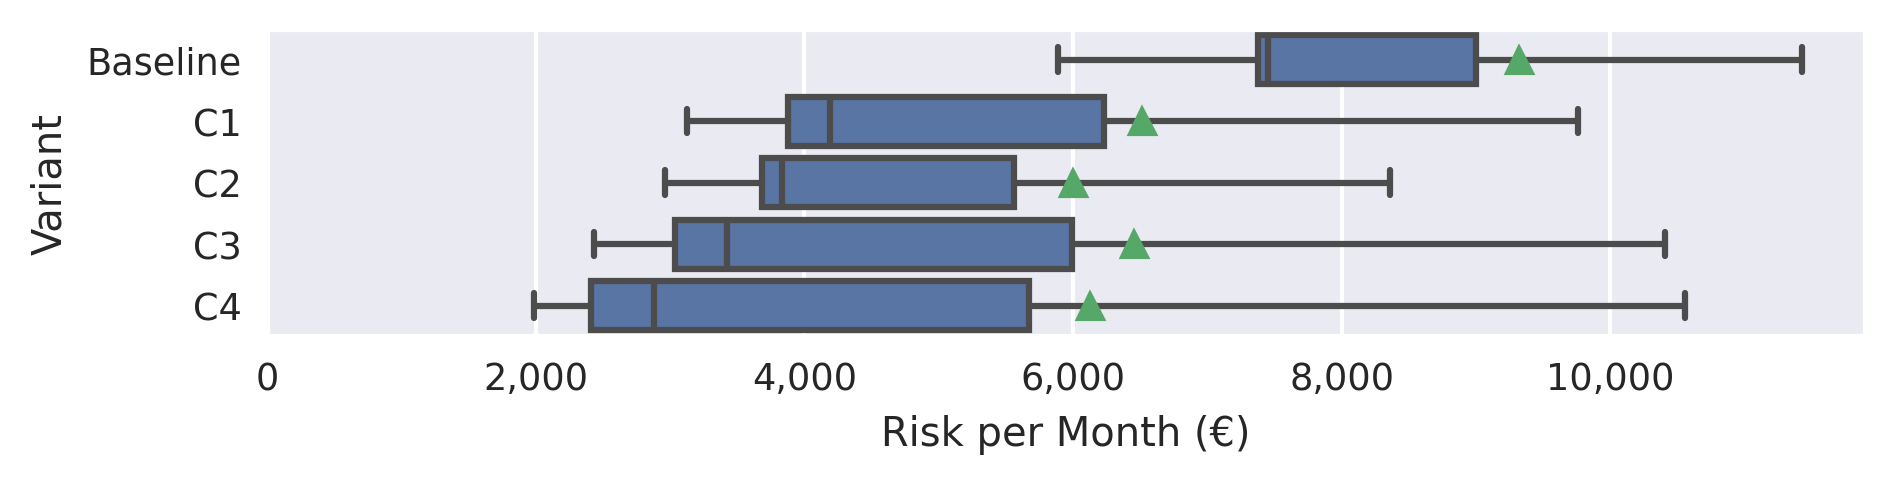

In [38]:
fig, ax = plt.subplots(figsize=figsize(1.5))

order = [
    "baseline",
    "B6",
    "B1",
    "B2",
    "B5",
]

ax = sns.boxplot(data=risk_opt_monthly, x="cost", y="candidate", ax=ax, order=order, showfliers=False, showmeans=True, palette=["C0"])

ax.set_ylabel("Variant")
ax.set_xlabel("Risk per Month (€)")
ax.set_yticklabels(["Baseline", "C1", "C2", "C3", "C4"])
ax.set_xlim(left=0)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

fig.savefig(os.path.join(FIGURE_PATH, "figure-10.pdf"))

## Figure 11

In [39]:
risk_workload = pd.read_parquet("data/risk/portfolio=workload", columns=["workload", "seed", "timestamp", "id", "cost", "value"], read_dictionary=["id"])
risk_workload = adjust_env(risk_workload, energy_price=241, co2_price=81, social_co2_price=395, pue=1.55)

In [40]:
risk_workload_pm = compute_monthly_risk(risk_workload, keys=["workload"], observed=True)
risk_workload_pm.groupby(["workload"])["cost"].describe()

,count,mean,std,min,25%,50%,75%,max
workload,,,,,,,,
azure,4096.0,6393.004621,513.777274,6164.527373,6169.634529,6180.792442,6410.253431,14398.486544
baseline,12288.0,8850.969918,6369.668978,5484.916036,6878.532789,6951.416838,8519.484214,105461.205032
bitbrains,4096.0,18118.268539,10359.943653,13178.205088,13611.749393,14156.018611,18218.185227,127504.926100
materna,16384.0,6793.682837,5227.863287,1279.972341,5981.667228,6606.570067,7581.173607,61750.568296


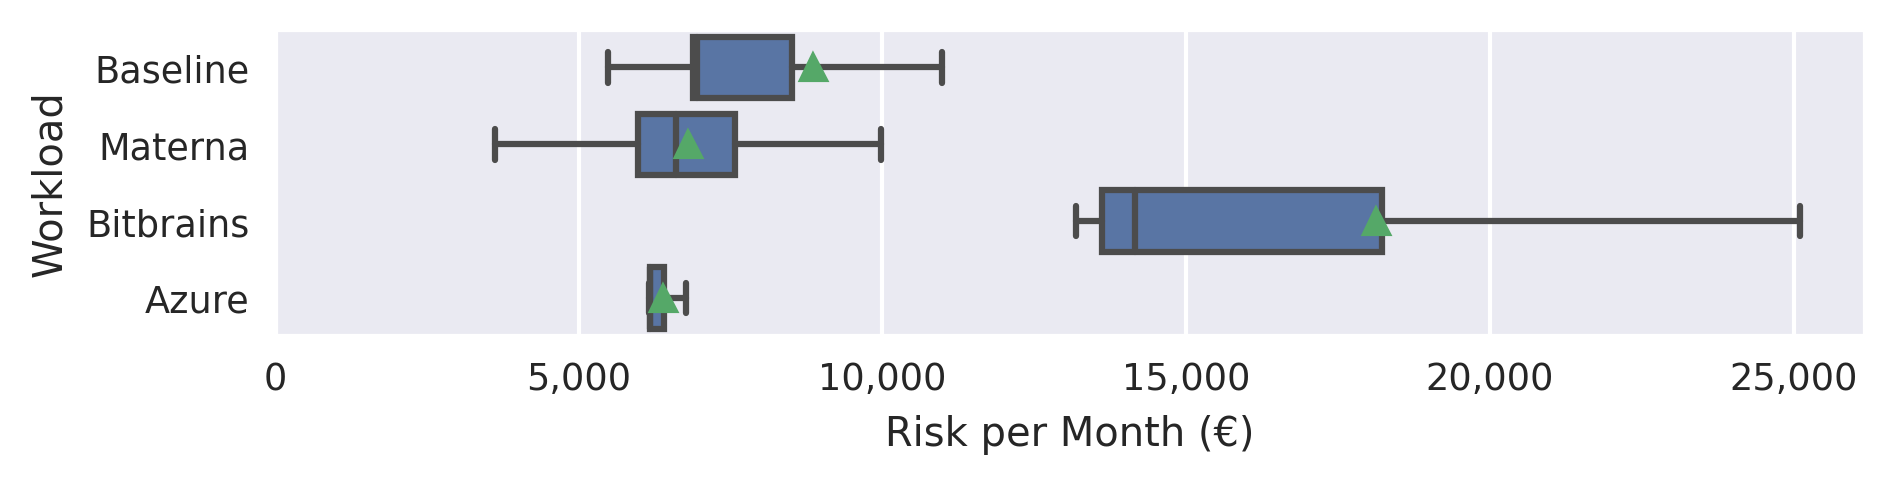

In [41]:
fig, ax = plt.subplots(figsize=figsize(1.5))

order = [
    "baseline",
    "materna",
    "bitbrains",
    "azure",
]

ax = sns.boxplot(data=risk_workload_pm, x="cost", y="workload", ax=ax, order=order, showfliers=False, showmeans=True, color="C0")

ax.set_ylabel("Workload")
ax.set_xlabel("Risk per Month (€)")
ax.set_yticklabels(["Baseline", "Materna", "Bitbrains", "Azure"])
ax.set_xlim(left=0)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

fig.savefig(os.path.join(FIGURE_PATH, "figure-11.pdf"))

## Figure 12

In [42]:
fig_12_data = pd.concat([
    compute_monthly_risk(risk_workload[risk_workload["workload"] == workload]).assign(workload=workload)
    for workload in ["baseline", "materna", "bitbrains", "azure"]
])
fig_12_data.groupby(["workload", "id"])["cost"].describe()

count         mean           std  \
workload  id                                                              
azure     customer:cpu_interference   4096.0     1.143881      1.913573   
          company:power               4096.0  2939.949369      0.857784   
          company:co2                 4096.0   549.392364      0.160295   
          society:co2                 4096.0  2679.135604      0.781687   
          customer:availability       4096.0   221.420538    498.902549   
          customer:latency            4096.0     1.962865     52.332758   
          company:host_saturation     4096.0     0.000000      0.000000   
          company:host_imbalance      4096.0     0.000000      0.000000   
baseline  customer:cpu_interference  12288.0     5.651365      3.171495   
          company:power              12288.0  3060.583146    310.894747   
          company:co2                12288.0   571.935363     58.097327   
          society:co2                12288.0  2789.067513    283.314126   
          customer:availability      12288.0  2400.890041   6229.949650   
          customer:latency           12288.0    21.275920   1058.479582   
          company:host_saturation    12288.0     0.325521      7.967276   
          company:host_imbalance     12288.0     1.241048     16.603722   
bitbrains customer:cpu_interference   4096.0   214.760477     12.400698   
          company:power               4096.0  4051.137716     28.567331   
          company:co2                 4096.0   757.041652      5.338416   
          society:co2                 4096.0  3691.746328     26.033017   
          customer:availability       4096.0  4593.579506  10482.282445   
          customer:latency            4096.0     3.819998     44.885771   
          company:host_saturation     4096.0  2348.968506     82.905520   
          company:host_imbalance      4096.0  2457.214355    106.240639   
materna   customer:cpu_interference  16384.0     0.000000      0.000000   
          company:power              16384.0  2441.474850   1064.228718   
          company:co2                16384.0   456.241748    198.873878   
          society:co2                16384.0  2224.882600    969.817058   
          customer:availability      16384.0  1670.583292   4324.260619   
          customer:latency           16384.0     0.500346     11.464967   
          company:host_saturation    16384.0     0.000000      0.000000   
          company:host_imbalance     16384.0     0.000000      0.000000   

                                             min          25%          50%  \
workload  id                                                                 
azure     customer:cpu_interference     0.000000     0.000000     0.192000   
          company:power              2929.461198  2939.807298  2940.264477   
          company:co2                 547.432425   549.365815   549.451249   
          society:co2                2669.577877  2679.006136  2679.422757   
          customer:availability         0.000000     0.000000     8.627073   
          customer:latency              0.000000     0.000000     0.000000   
          company:host_saturation       0.000000     0.000000     0.000000   
          company:host_imbalance        0.000000     0.000000     0.000000   
baseline  customer:cpu_interference     0.000000     3.175998     4.943321   
          company:power              2226.136984  2626.242370  3276.095220   
          company:co2                 416.001266   490.769508   612.208400   
          society:co2                2028.648151  2393.258711  2985.460715   
          customer:availability         0.000000     0.000000   223.872000   
          customer:latency              0.000000     0.000000     0.000000   
          company:host_saturation       0.000000     0.000000     0.000000   
          company:host_imbalance        0.000000     0.000000     0.000000   
bitbrains customer:cpu_interference   127.919948   212.979734   213.171734   
      

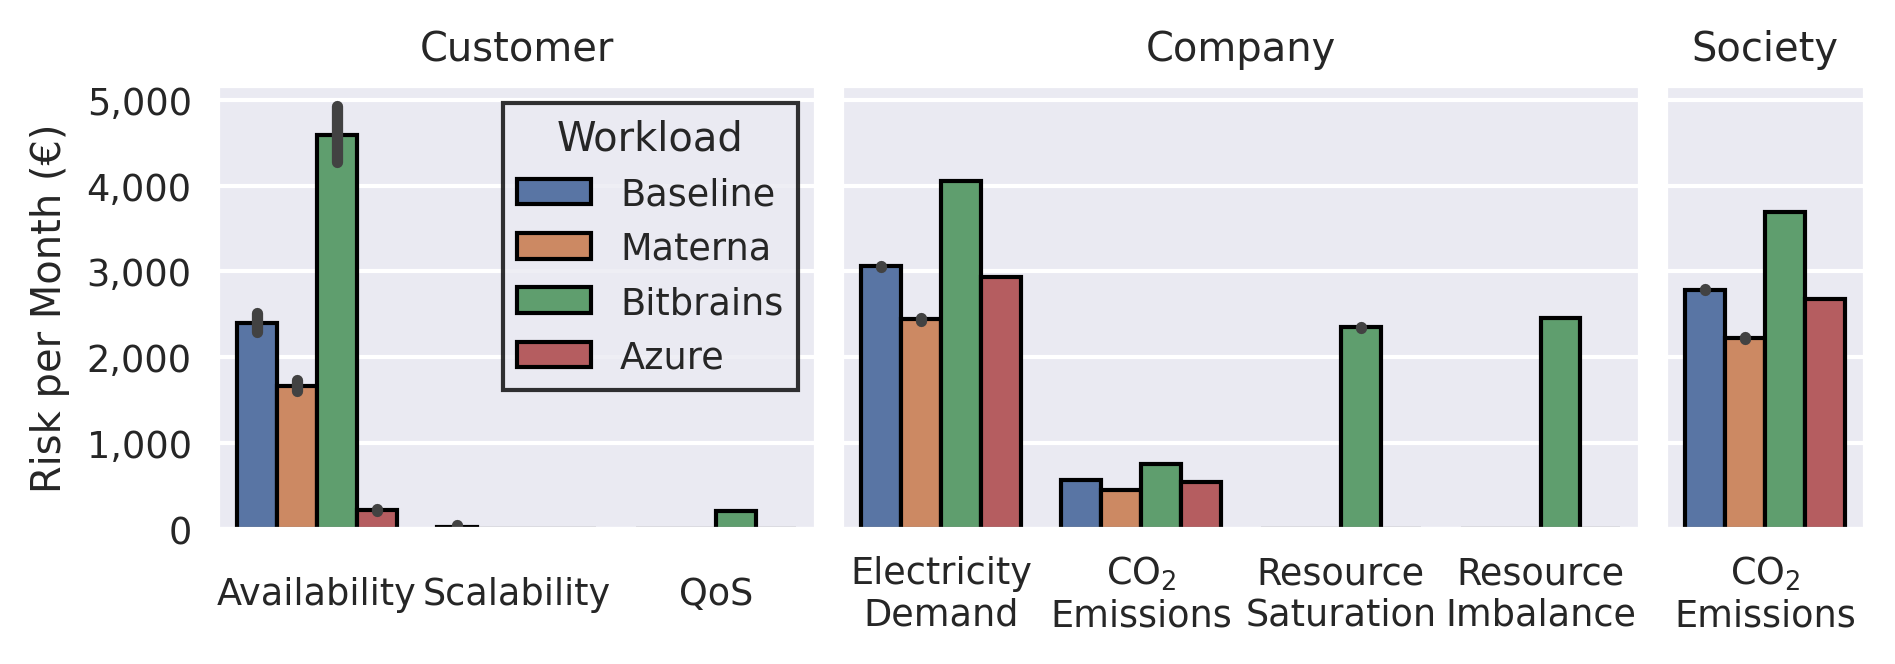

In [43]:
fig, ax = plt.subplots(1, 3, figsize=figsize(2.1), sharey=True, gridspec_kw={"width_ratios": [3, 4, 1]})

hue = "workload"
hue_order = ["baseline", "materna", "bitbrains", "azure"]

cx_data = fig_12_data[fig_12_data["id"].str.startswith("customer")]
cx_order = ["customer:availability", "customer:latency", "customer:cpu_interference"]
cx_labels = ["Availability", "Scalability", "QoS"]

co_data = fig_12_data[fig_12_data["id"].str.startswith("company")]
co_order = ["company:power", "company:co2", "company:host_saturation", "company:host_imbalance"]
co_labels = ["Electricity\nDemand", "CO$_2$\nEmissions", "Resource\nSaturation", "Resource\nImbalance"]

soc_data = fig_12_data[fig_12_data["id"].str.startswith("society")]
soc_order = ["society:co2"]
soc_labels = ["CO$_2$\nEmissions"]

fmt = mtick.StrMethodFormatter("{x:,.0f}")

sns.barplot(x="id", y="cost", data=cx_data, ax=ax[0], order=cx_order, hue=hue, hue_order=hue_order, edgecolor="black")

ax[0].set_ylabel("Risk per Month (€)")
ax[0].set_xticklabels(cx_labels)
ax[0].set_xlabel("")
ax[0].set_title("Customer")
ax[0].yaxis.set_major_formatter(fmt)

sns.barplot(x="id", y="cost", data=co_data, ax=ax[1], order=co_order, hue=hue, hue_order=hue_order, edgecolor="black")

ax[1].set_ylabel("")
ax[1].set_xticklabels(co_labels)
ax[1].set_xlabel("")
ax[1].set_title("Company")
ax[1].legend([],[], frameon=False)
ax[1].yaxis.set_major_formatter(fmt)


sns.barplot(x="id", y="cost", data=soc_data, ax=ax[2], order=soc_order, hue=hue, hue_order=hue_order, edgecolor="black")

ax[2].set_ylabel("")
ax[2].set_xticklabels(soc_labels)
ax[2].set_xlabel("")
ax[2].set_title("Society")
ax[2].yaxis.set_major_formatter(fmt)
ax[2].legend([],[], frameon=False)

fig.align_xlabels(ax)

for x in ax:
    align_labels(x, va="center")

legend = ax[0].get_legend()
legend.set_title("Workload")
labels = ["Baseline", "Materna", "Bitbrains", "Azure"]

for i, txt in enumerate(legend.get_texts()):
    txt.set_text(labels[i])

ax[1].legend([],[], frameon=False)

fig.savefig(os.path.join(FIGURE_PATH, 'figure-12.pdf'))

## Table 4 (Performance)

In [44]:
perf_scales = {
    "baseline": 1,
    "baseline-50%": 0.5,
    "baseline-25%": 0.25,
    "baseline-10%": 0.1,
    "baseline-5%": 0.05
}

perf = pd.read_parquet('data/perf', columns=["workload", "engine", "duration", "mem_usage"], read_dictionary=["workload", "engine"])
perf['duration'] = pd.to_timedelta(perf['duration'], unit='ms').dt.total_seconds()
perf['mem_usage_mb'] = perf['mem_usage'] / 1000000
perf["scale"] = perf["workload"].map(perf_scales).astype('float')
perf

,workload,engine,duration,mem_usage,mem_usage_mb,scale
0,baseline-10%,cloudsim-plus,28.292,100146432,100.146432,0.1
1,baseline-10%,cloudsim-plus,28.237,100253176,100.253176,0.1
2,baseline-10%,cloudsim-plus,28.113,100394856,100.394856,0.1
3,baseline-10%,cloudsim-plus,28.195,100394856,100.394856,0.1
4,baseline-10%,cloudsim-plus,28.064,100395072,100.395072,0.1
...,...,...,...,...,...,...
243,baseline,opendc,3.319,939337696,939.337696,1.0
244,baseline,opendc,3.312,939337696,939.337696,1.0
245,baseline,opendc,3.270,939337696,939.337696,1.0
246,baseline,opendc,3.340,939338336,939.338336,1.0


### Runtime

In [45]:
perf.groupby(["scale", "engine"])["duration"].agg(['mean', 'std'])

mean       std
scale engine                              
0.05  cloudsim-plus     7.528844  0.022065
      opendc            0.106063  0.009009
0.10  cloudsim-plus    28.159594  0.080745
      opendc            0.162375  0.007665
0.25  cloudsim-plus   159.776000  1.082496
      opendc            0.663781  0.006950
0.50  cloudsim-plus   396.891625  0.921940
      opendc            1.688219  0.010099
1.00  cloudsim-plus  1099.831375  3.010599
      opendc            3.289656  0.032961

### Peak Memory Usage

In [46]:
perf.groupby(["scale", "engine"])["mem_usage_mb"].agg(['mean', 'std'])

mean       std
scale engine                             
0.05  cloudsim-plus   59.732214  0.050803
      opendc          59.006111  0.054520
0.10  cloudsim-plus  100.386606  0.050941
      opendc         100.958704  0.052747
0.25  cloudsim-plus  246.317443  0.095626
      opendc         246.369159  0.051304
0.50  cloudsim-plus  483.416302  0.097220
      opendc         484.694274  0.052114
1.00  cloudsim-plus  942.051142  0.097921
      opendc         939.323446  0.051325